# Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

__________________________________________________________________
# Introducion:

## Data cleaning process
### Iteration 1
There will be two sections in this notebook. The first portion [Iteration 1](#Iteration_1), The first dataset collected in [01_sub_reddit_data](../Data/01_sub_reddit_data.csv)  contained an inital 3992 records; however upon our first analysis, we found that nearly 70% of our titles were removed by a moderator. We assume that removed post violate the subreddit guidelines and wont be representive of the subreddits characteristics. Although we notice this discrepancy we continued exploring the data, so we can reference it after we gather more data. [Iteration 2](#Iteration_2) will use all data from Iteration 1 because those removed post may be used as a featue.
### Iteraton 2
We then went back to the data collection notebook [01_data_collecting](../Code/01_data_collecting.ipynb) and added parameters to pull post that had a minimum of 4 post and was not removed by a moderator; however, the removed by moderator parameter was depercated. Then we proceeded to clean the data of the new column in [Iteration 2](#Iteration_2). We combined Iteration 1 and Iteration 2 because we also wanted to keep the removed comments. There is a possability one subreddit has more post removed than the other, so that may be a good featue to have. 
_________________________________________________________________

# Iteration 1

## Load Data

In [6]:
df = pd.read_csv('../Data/01_sub_reddits_data.csv')
df.head(1)

,subreddit,selftext,author_fullname,gilded,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,...,num_crossposts,media,is_video,retrieved_utc,updated_utc,utc_datetime_str,post_hint,preview,link_flair_template_id,author_cakeday
0,AskWomen,[removed],t2_v4u69ho5,0,How about true friendship between men and wome...,[],r/AskWomen,False,6,NaN,...,0,NaN,False,1682375081,1682375081,2023-04-24 22:24:26,NaN,NaN,NaN,NaN


## Clean and select features

This portion is where we will select our inital features. As we clean our data we will continue to add additional features.

The inital features we selected were
|Feature|Reason|
|-------|------|
|subreddit|Our target variable, used to see the differences in between subreddits|
|title|Our primary feature we're using to identify ownership to a subreddit|
|utc_datetime_str|the human readable date and timestamp, will use pandas functions to engineer this feature|
|hidden| if a post has been hidden, a certain post may have more hidden post|
|num_comments|a subredit my have more comment activity on posts|

In [7]:
df.columns.sort_values()

Index(['all_awardings', 'allow_live_comments', 'archived', 'author',
       'author_cakeday', 'author_flair_background_color',
       'author_flair_css_class', 'author_flair_richtext',
       'author_flair_template_id', 'author_flair_text',
       'author_flair_text_color', 'author_flair_type', 'author_fullname',
       'author_patreon_flair', 'author_premium', 'awarders', 'can_gild',
       'category', 'content_categories', 'contest_mode', 'created_utc',
       'discussion_type', 'distinguished', 'domain', 'edited', 'gilded',
       'gildings', 'hidden', 'hide_score', 'id', 'is_created_from_ads_ui',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_css_class',
       'link_flair_richtext', 'link_flair_template_id', 'link_flair_text',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media',
       'media_embed', 'media_only', 'no_follow

In [8]:
clean_df=df[['id', 'subreddit','title', 'utc_datetime_str', 'hidden', 'num_comments']]

In [9]:
len(clean_df)

3992

In [10]:
#set an index that we can reference if needed
clean_df.set_index('id', inplace=True)

In [11]:
len(clean_df)

3992

In [12]:
clean_df.head(3)

,subreddit,title,utc_datetime_str,hidden,num_comments
id,,,,,
12xyt9k,AskWomen,How about true friendship between men and wome...,2023-04-24 22:24:26,False,0
12xymt1,AskWomen,Does this mean she’s not interested? What shou...,2023-04-24 22:18:10,False,1
12xylur,AskWomen,What’s something that your brain cannot compre...,2023-04-24 22:17:10,False,0


## Feature engineering

### Creating a date column
This portion is used to get the date of a post, and identify what day of the week of a post

In [13]:
#convert the utc_datetime_str into a date time data type
clean_df.loc[:, 'utc_datetime_str']= pd.to_datetime(clean_df.loc[:, 'utc_datetime_str'])

C:\Users\Derik\AppData\Local\Temp\ipykernel_15556\1726003547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.loc[:, 'utc_datetime_str']= pd.to_datetime(clean_df.loc[:, 'utc_datetime_str'])


In [14]:
clean_df.head(3)

,subreddit,title,utc_datetime_str,hidden,num_comments
id,,,,,
12xyt9k,AskWomen,How about true friendship between men and wome...,2023-04-24 22:24:26,False,0
12xymt1,AskWomen,Does this mean she’s not interested? What shou...,2023-04-24 22:18:10,False,1
12xylur,AskWomen,What’s something that your brain cannot compre...,2023-04-24 22:17:10,False,0


In [15]:
clean_df.dtypes

subreddit                   object
title                       object
utc_datetime_str    datetime64[ns]
hidden                        bool
num_comments                 int64
dtype: object

In [16]:
#referenced this stack overflow: https://stackoverflow.com/questions/28009370/get-weekday-day-of-week-for-datetime-column-of-dataframe
clean_df['day_name'] = clean_df['utc_datetime_str'].apply(lambda x: x.day_name())

C:\Users\Derik\AppData\Local\Temp\ipykernel_15556\229520572.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['day_name'] = clean_df['utc_datetime_str'].apply(lambda x: x.day_name())


In [17]:
clean_df.head(3)

,subreddit,title,utc_datetime_str,hidden,num_comments,day_name
id,,,,,,
12xyt9k,AskWomen,How about true friendship between men and wome...,2023-04-24 22:24:26,False,0,Monday
12xymt1,AskWomen,Does this mean she’s not interested? What shou...,2023-04-24 22:18:10,False,1,Monday
12xylur,AskWomen,What’s something that your brain cannot compre...,2023-04-24 22:17:10,False,0,Monday


### Get titles that are a-z only.
This is to prevent post that are none english

### Creating a title word count column
This portion is used to check the word count of a title

In [18]:
clean_df['title_word_count'] = clean_df['title'].apply(lambda text: len(text.split()))

C:\Users\Derik\AppData\Local\Temp\ipykernel_15556\1397197032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['title_word_count'] = clean_df['title'].apply(lambda text: len(text.split()))


In [19]:
#see distribution of word counts
clean_df['title_word_count'].value_counts(sort=True)

9     333
8     325
10    312
12    290
11    269
7     252
13    213
6     206
14    205
15    198
17    153
16    150
18    123
5     108
19    100
20     76
4      74
21     58
23     57
3      51
22     50
2      47
1      42
24     40
25     39
26     27
27     25
31     20
28     19
29     14
30     13
32     11
35      9
34      7
49      6
36      6
39      5
33      5
52      5
37      4
44      4
42      3
38      3
47      3
56      3
41      3
59      3
54      3
43      3
53      2
51      2
40      2
45      2
50      2
46      2
48      1
62      1
58      1
63      1
60      1
Name: title_word_count, dtype: int64

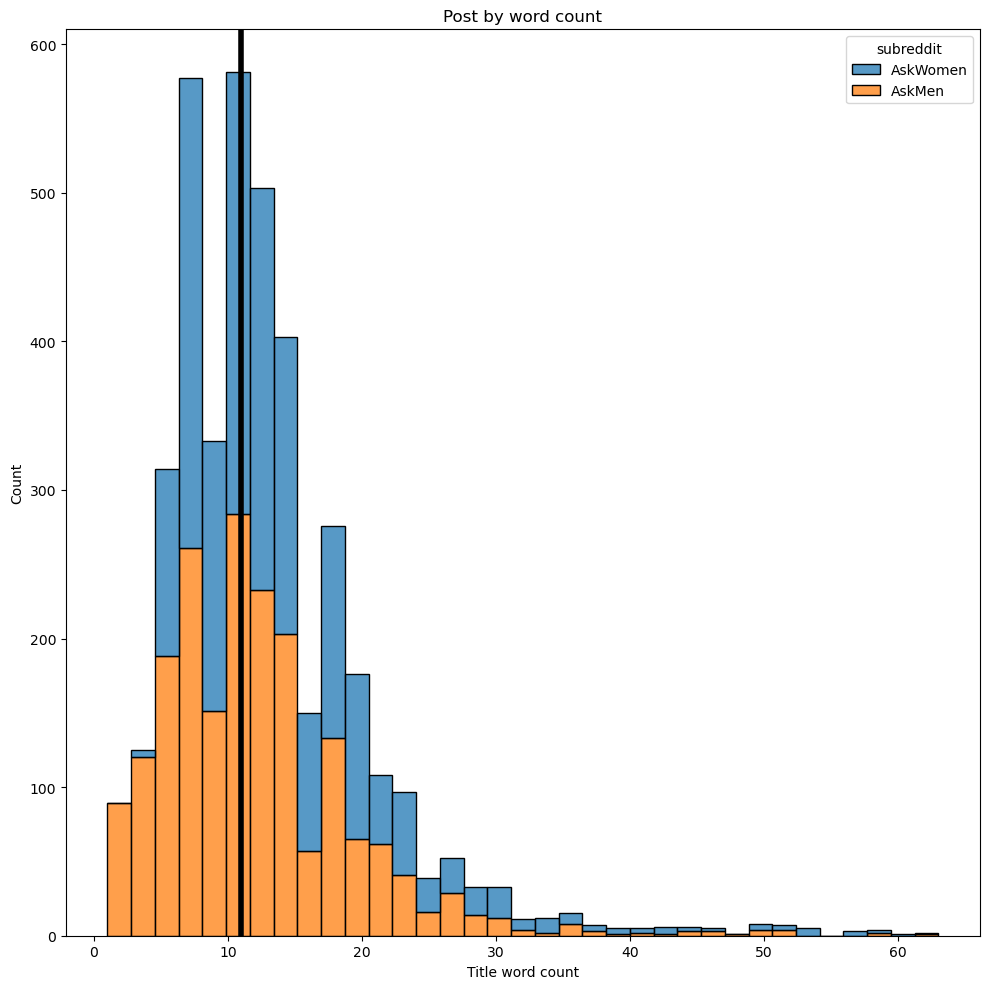

In [180]:
plt.figure(figsize=(10,10))
plt.title('Post by word count')
sns.histplot(data= clean_df, multiple ="stack", x = 'title_word_count', hue='subreddit', bins=35)
plt.axvline(x=clean_df['title_word_count'].median(), color='black', linewidth=4)
plt.xlabel("Title word count")
plt.tight_layout()
plt.savefig('../Figures/eda/post_by_word_count.png')

It appears there are vastly more post in askwomen and the median words in titles 

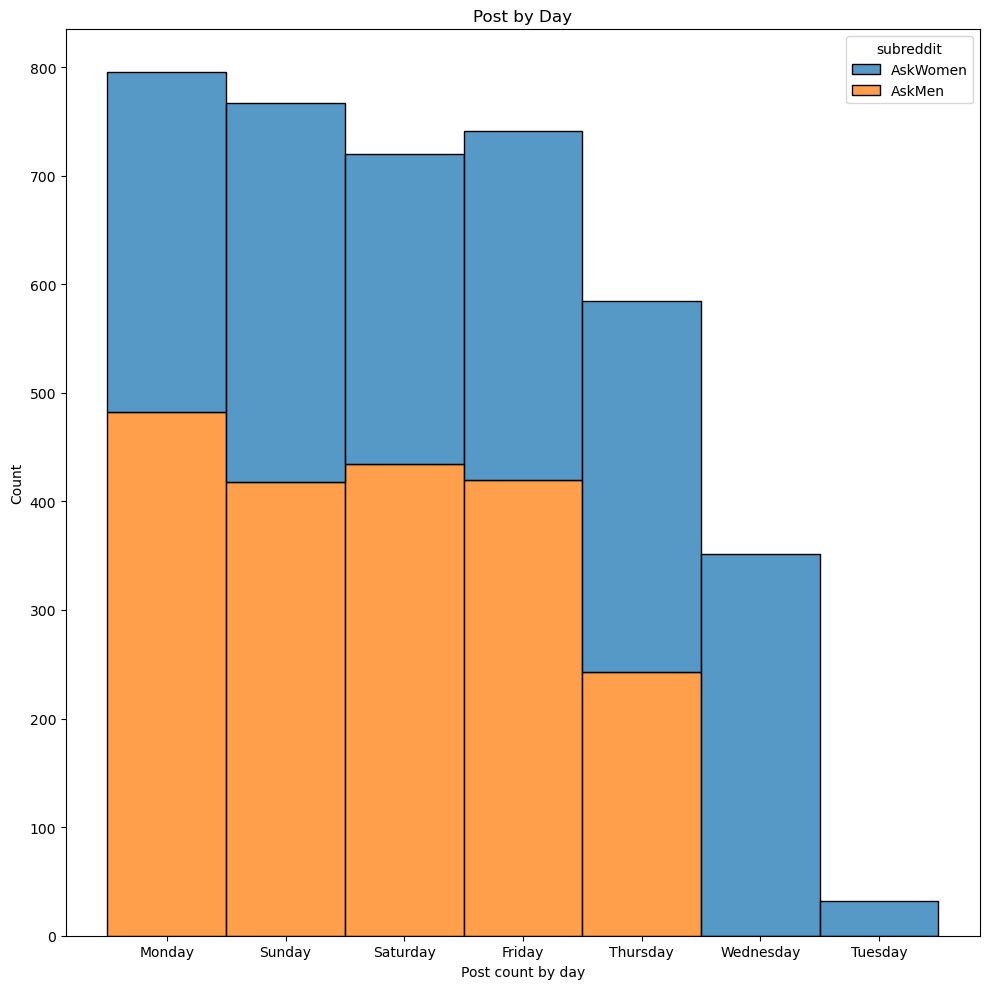

In [179]:
#Overview of post frequencies by day
plt.figure(figsize=(10,10))
plt.title('Post by Day')
sns.histplot(data= clean_df, multiple ="stack", x = 'day_name', hue='subreddit')
plt.xlabel("Post count by day")
plt.tight_layout()
plt.savefig('../Figures/eda/post_by_day.png');

It appears the frequency of post is significantly higher in AskWomen that it is in askmen. The days with the fewest post are from wednesday and tuesday.

### Sentiment analysis

In [22]:
sent = SentimentIntensityAnalyzer()

In [23]:
#test to see the output of the analyzer
sent.polarity_scores(clean_df['title'][0])

{'neg': 0.0, 'neu': 0.584, 'pos': 0.416, 'compound': 0.6908}

In [24]:
#testing to see how to index the dictionary
sent.polarity_scores(clean_df['title'][0])['neu']

0.584

In [ ]:
#splitting scores into columns
clean_df['negative_score'] = [sent.polarity_scores(clean_df['title'][i])['neg'] for i in range(len(clean_df['title']))]
clean_df['neutral_score'] = [sent.polarity_scores(clean_df['title'][i])['neu'] for i in range(len(clean_df['title']))]
clean_df['positive_score'] = [sent.polarity_scores(clean_df['title'][i])['pos'] for i in range(len(clean_df['title']))]
clean_df['compound_score'] = [sent.polarity_scores(clean_df['title'][i])['compound'] for i in range(len(clean_df['title']))]

In [26]:
clean_df.head(5)

,subreddit,title,utc_datetime_str,hidden,num_comments,day_name,title_word_count,negative_score,neutral_score,positive_score,compound_score
id,,,,,,,,,,,
12xyt9k,AskWomen,How about true friendship between men and wome...,2023-04-24 22:24:26,False,0,Monday,10,0.000,0.584,0.416,0.6908
12xymt1,AskWomen,Does this mean she’s not interested? What shou...,2023-04-24 22:18:10,False,1,Monday,10,0.247,0.753,0.000,-0.3855
12xylur,AskWomen,What’s something that your brain cannot compre...,2023-04-24 22:17:10,False,0,Monday,12,0.000,1.000,0.000,0.0000
12xylln,AskWomen,Does this mean she’s not interested? What shou...,2023-04-24 22:16:55,False,1,Monday,10,0.247,0.753,0.000,-0.3855
12xy4mb,AskWomen,"Out of curiosity, what are reasons TO have chi...",2023-04-24 22:00:29,False,1,Monday,9,0.000,1.000,0.000,0.0000


### Checking the 'hidden' column
This portion is to check to see if a post has been hidden

In [27]:
#check the hidden column
clean_df['hidden'].value_counts()

False    3992
Name: hidden, dtype: int64

In [28]:
#removed the hidden column since there are only false values
clean_df.drop(columns = 'hidden', inplace=True)

C:\Users\Derik\AppData\Local\Temp\ipykernel_15556\1289743119.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.drop(columns = 'hidden', inplace=True)


Since none of the post in the dataset are hidden, I decided to just remove this feature because it doesnt differentiate our subreddits. 

### Checking the num_comments column
This portion is used to check how many comments are in each post.

In [29]:
'''
I had assumed num_comments was the number of comments within a thread, but thought the valuecounts was weird,
so when I looked at the api documentation it didnt specific what it was.
The Api documentation just states that num_comments is an integer between 1 and 500.

Will need to see how many post have been removed as well because that indicates a post was removed before
people could respond.
'''
clean_df['num_comments'].value_counts()

1    2300
0    1691
3       1
Name: num_comments, dtype: int64

________________________________________________________________________________
### Checking the removed column
This portion is used to check if a significant number of our post were removed

In [30]:
#check percent of post removed, df is the entire dataset without filtering
df['removed_by_category'].value_counts() / len(df)

moderator           0.666333
automod_filtered    0.047595
deleted             0.018537
reddit              0.015030
Name: removed_by_category, dtype: float64

Here is appears about 70% of post have been removed. I will now create a feature for our dataframe to determine if a post has been removed.

In [ ]:
#check to see first few, here we see a nan, so we assume its not removed
df['removed_by_category'].head(5)

0    automod_filtered
1           moderator
2                 NaN
3           moderator
4           moderator
Name: removed_by_category, dtype: object

In [174]:
#check to see if the true/false match
df['removed_by_category'].notnull().astype(int)

id
12xyt9k    1
12xymt1    1
12xylur    0
12xylln    1
12xy4mb    1
          ..
12t0j9u    0
12t0c3m    0
12t06yb    1
12t03et    0
12szogj    0
Name: removed_by_category, Length: 3992, dtype: int32

In [112]:
df.set_index('id', inplace=True)

In [115]:
#get the removed by category from the orignal df to calculate the ammount of removedp ost in each subreddit
clean_df = clean_df.merge(df['removed_by_category'], left_index=True, right_index=True)

In [117]:
#NaNs indicate that a post was or was not removed,
clean_df['is_removed'] = clean_df['removed_by_category'].notnull().astype(int)

In [118]:
#check the output
clean_df.head()

,subreddit,title,utc_datetime_str,num_comments,day_name,title_word_count,negative_score,neutral_score,positive_score,compound_score,is_removed,removed_by_category
id,,,,,,,,,,,,
12xyt9k,AskWomen,How about true friendship between men and wome...,2023-04-24 22:24:26,0.0,Monday,10.0,0.000,0.584,0.416,0.6908,1,automod_filtered
12xymt1,AskWomen,Does this mean she’s not interested? What shou...,2023-04-24 22:18:10,1.0,Monday,10.0,0.247,0.753,0.000,-0.3855,1,moderator
12xylur,AskWomen,What’s something that your brain cannot compre...,2023-04-24 22:17:10,0.0,Monday,12.0,0.000,1.000,0.000,0.0000,0,NaN
12xylln,AskWomen,Does this mean she’s not interested? What shou...,2023-04-24 22:16:55,1.0,Monday,10.0,0.247,0.753,0.000,-0.3855,1,moderator
12xy4mb,AskWomen,"Out of curiosity, what are reasons TO have chi...",2023-04-24 22:00:29,1.0,Monday,9.0,0.000,1.000,0.000,0.0000,1,moderator


In [167]:
#create a dataframe of the number of post removed in a subreddit
subreddit = clean_df.groupby('subreddit')['is_removed'].sum().reset_index()

In [168]:
#check output
subreddit.head()

,subreddit,is_removed
0,AskMen,1352
1,AskWomen,1632


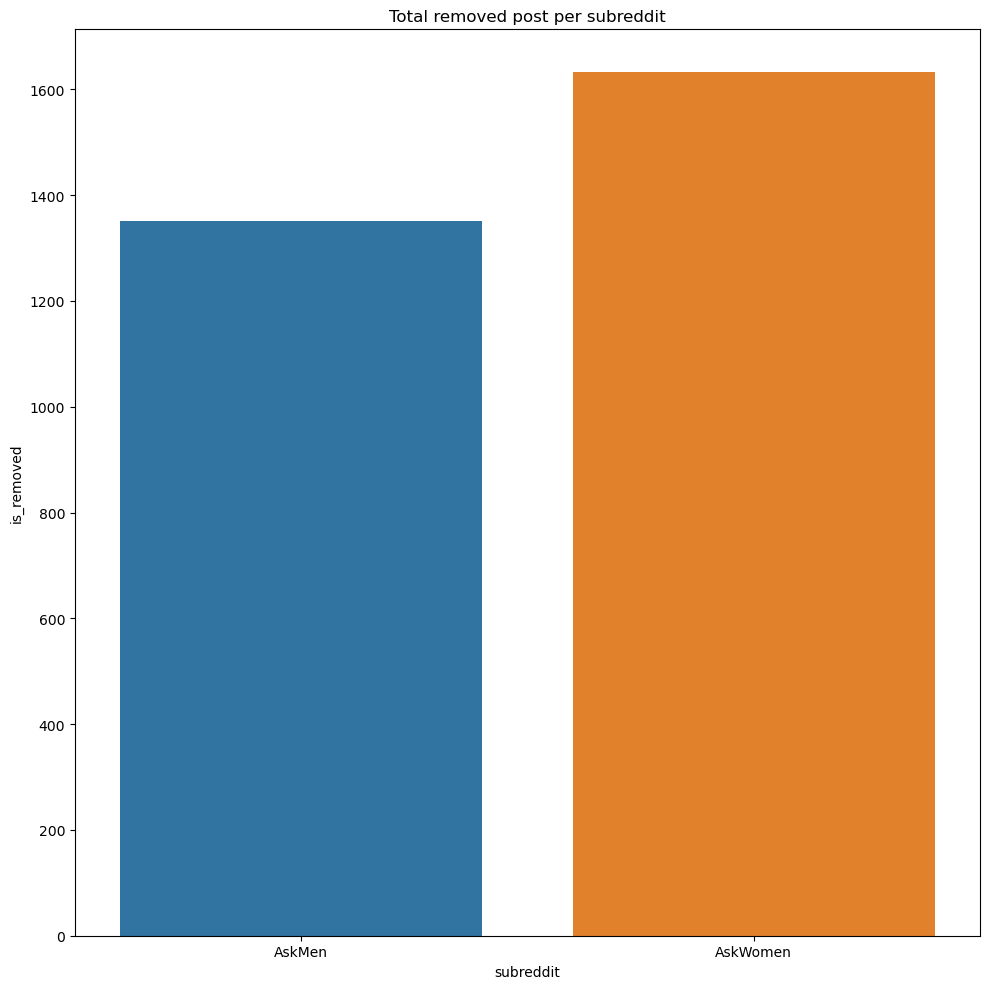

In [177]:
#plot the total number of post removed in each sub reddit
plt.figure(figsize=(10,10))
plt.title("Total removed post per subreddit")
sns.barplot(x = 'subreddit', y = 'is_removed', data = subreddit)
plt.tight_layout()
plt.savefig('../Figures/eda/total_removed_posts.png')

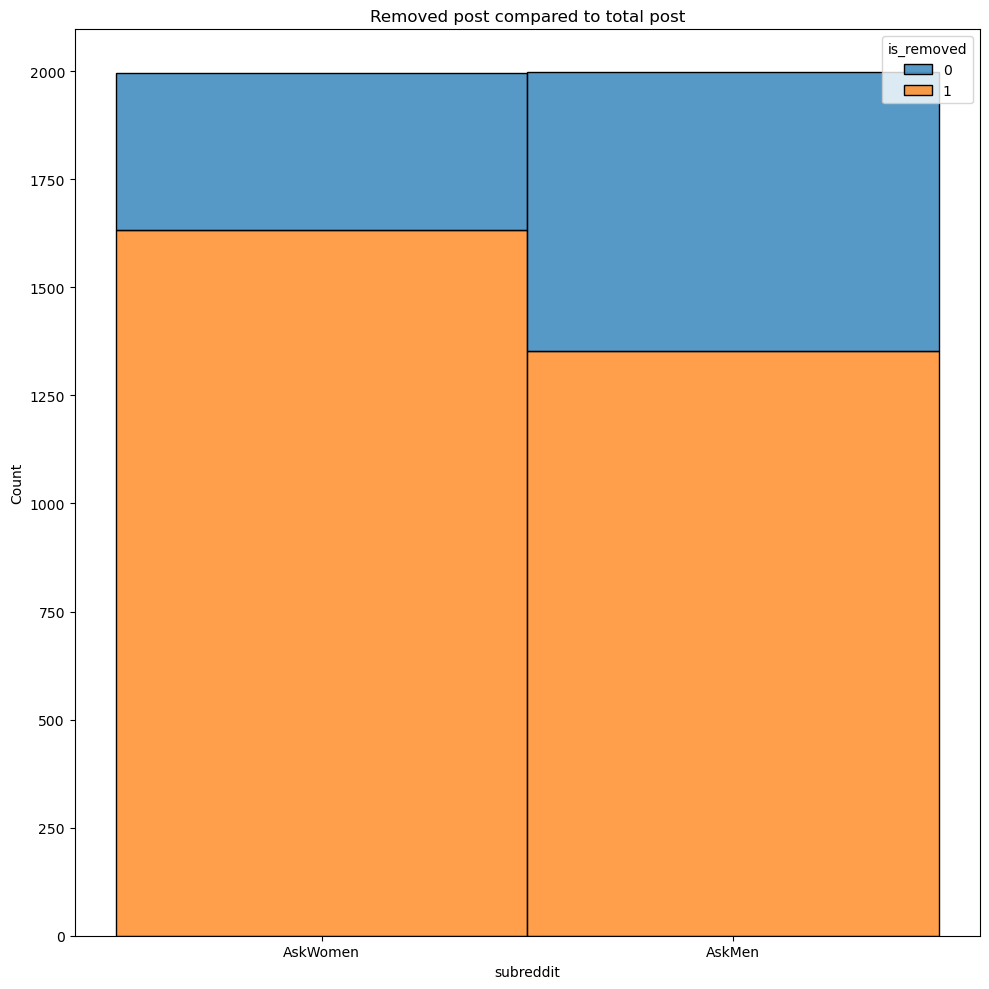

In [178]:
plt.figure(figsize=(10,10))
plt.title('Removed post compared to total post')
sns.histplot(data= clean_df, multiple ="stack", x = clean_df['subreddit'], hue='is_removed', bins=35)
plt.tight_layout()
plt.savefig('../Figures/eda/stacked_removed_posts.png')

In [133]:
clean_df['is_removed'].value_counts()

1    2984
0    1008
Name: is_removed, dtype: int64

Close to 75% of our data has been removed. Which is intresting. I wonder what type of questions get removed and which subreddit is more "heavily" moderated. With a high numer of removed post, it makes sense for the low number of comments, but it still feels low.

In [35]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3992 entries, 12xyt9k to 12szogj
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   subreddit         3992 non-null   object        
 1   title             3992 non-null   object        
 2   utc_datetime_str  3992 non-null   datetime64[ns]
 3   num_comments      3992 non-null   int64         
 4   day_name          3992 non-null   object        
 5   title_word_count  3992 non-null   int64         
 6   negative_score    3992 non-null   float64       
 7   neutral_score     3992 non-null   float64       
 8   positive_score    3992 non-null   float64       
 9   compound_score    3992 non-null   float64       
 10  is_removed        0 non-null      float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(3)
memory usage: 503.3+ KB


## Export cleaned data to a CSV

In [36]:
clean_df.head(1)

,subreddit,title,utc_datetime_str,num_comments,day_name,title_word_count,negative_score,neutral_score,positive_score,compound_score,is_removed
id,,,,,,,,,,,
12xyt9k,AskWomen,How about true friendship between men and wome...,2023-04-24 22:24:26,0,Monday,10,0.0,0.584,0.416,0.6908,NaN


In [37]:
clean_df.to_csv('../Data/01_sub_reddit_data_clean.csv')

## Vectorizing title data

In [38]:
#loading in data, so we dont have to run the entire notebook again
vect_df = pd.read_csv('../Data/01_sub_reddit_data_clean.csv')

In [39]:
vect_df.head(1)

,id,subreddit,title,utc_datetime_str,num_comments,day_name,title_word_count,negative_score,neutral_score,positive_score,compound_score,is_removed
0,12xyt9k,AskWomen,How about true friendship between men and wome...,2023-04-24 22:24:26,0,Monday,10,0.0,0.584,0.416,0.6908,NaN


In [40]:
cvec = CountVectorizer(stop_words='english')
X= vect_df['title']
X_cv = cvec.fit_transform(X)
X_cv.shape

(3992, 4600)

In [41]:
words_df = pd.DataFrame(X_cv.todense(), columns=cvec.get_feature_names_out())
words_df.head()

,0ft,10,100,1000,10k,11,12,120,13,15,...,youve,yr,yrs,zaralynn,zodiac,zone,вопросы,задавайте,миллионеров,сын
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Here we noticed there there are some russion characters which will need to be removed. before proceeding to our modeling stage. We will create some visualizations of the top common words first to see if there are any concerns we need to worry about. Then will return to our data collection phase.

_______________________________________________________

## visualizing top 10 words

In [42]:
women_word = words_df[vect_df['subreddit'] == 'AskWomen'].sum().sort_values(ascending=False)

In [43]:
men_word = words_df[vect_df['subreddit'] == 'AskMen'].sum().sort_values(ascending=False)

In [44]:
women_word.head(10)

women           314
did             155
men             120
feel            118
partner         116
like            112
man             109
does            101
relationship     98
guy              95
dtype: int64

Text(0.5, 1.0, 'Top 10 words in AskWomen')

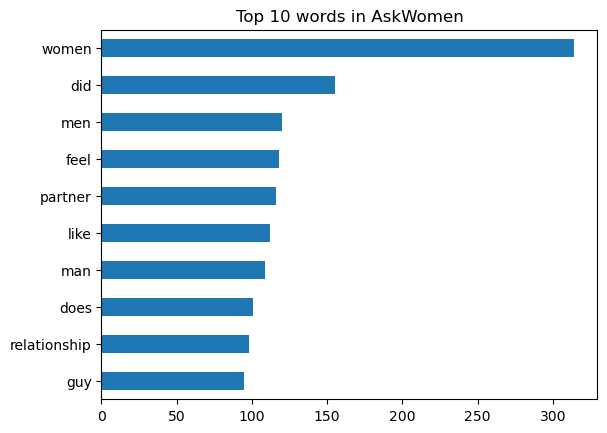

In [45]:
women_word.head(10).plot(kind ='barh').invert_yaxis()
plt.title('Top 10 words in AskWomen')

Here we see the top words in the AskWomen subreddit. Aside from nouns, it seems relationships is the most frequent topic in this subreddit.

In [46]:
men_word.head(10)

men             361
women           116
woman           115
guys            106
did             106
like             99
girl             84
relationship     82
man              74
think            73
dtype: int64

Text(0.5, 1.0, 'Top 10 words in Askmen')

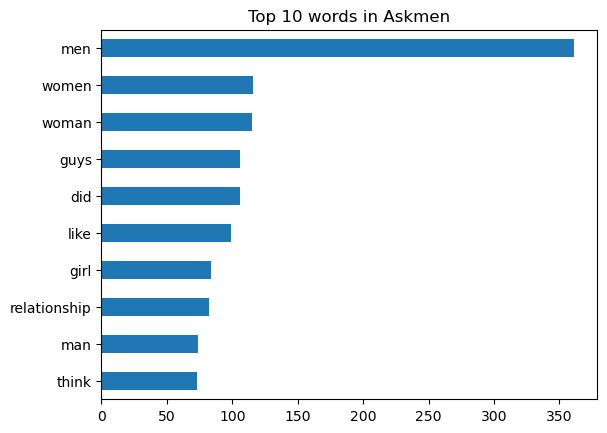

In [47]:
men_word.head(10).plot(kind ='barh').invert_yaxis()
plt.title('Top 10 words in Askmen')

It apears men, women, and woman appear freqently in both subreddits, so we can leave those features in when predicting what subreddit a post belongs to. Aside from those, it appears relationships is also a popular topic within this subreddit. However, it should be noted we only have about 2000 observations from each subreddit.

To convey this to stakeholders, we will create a side by side visualization of our word counts.

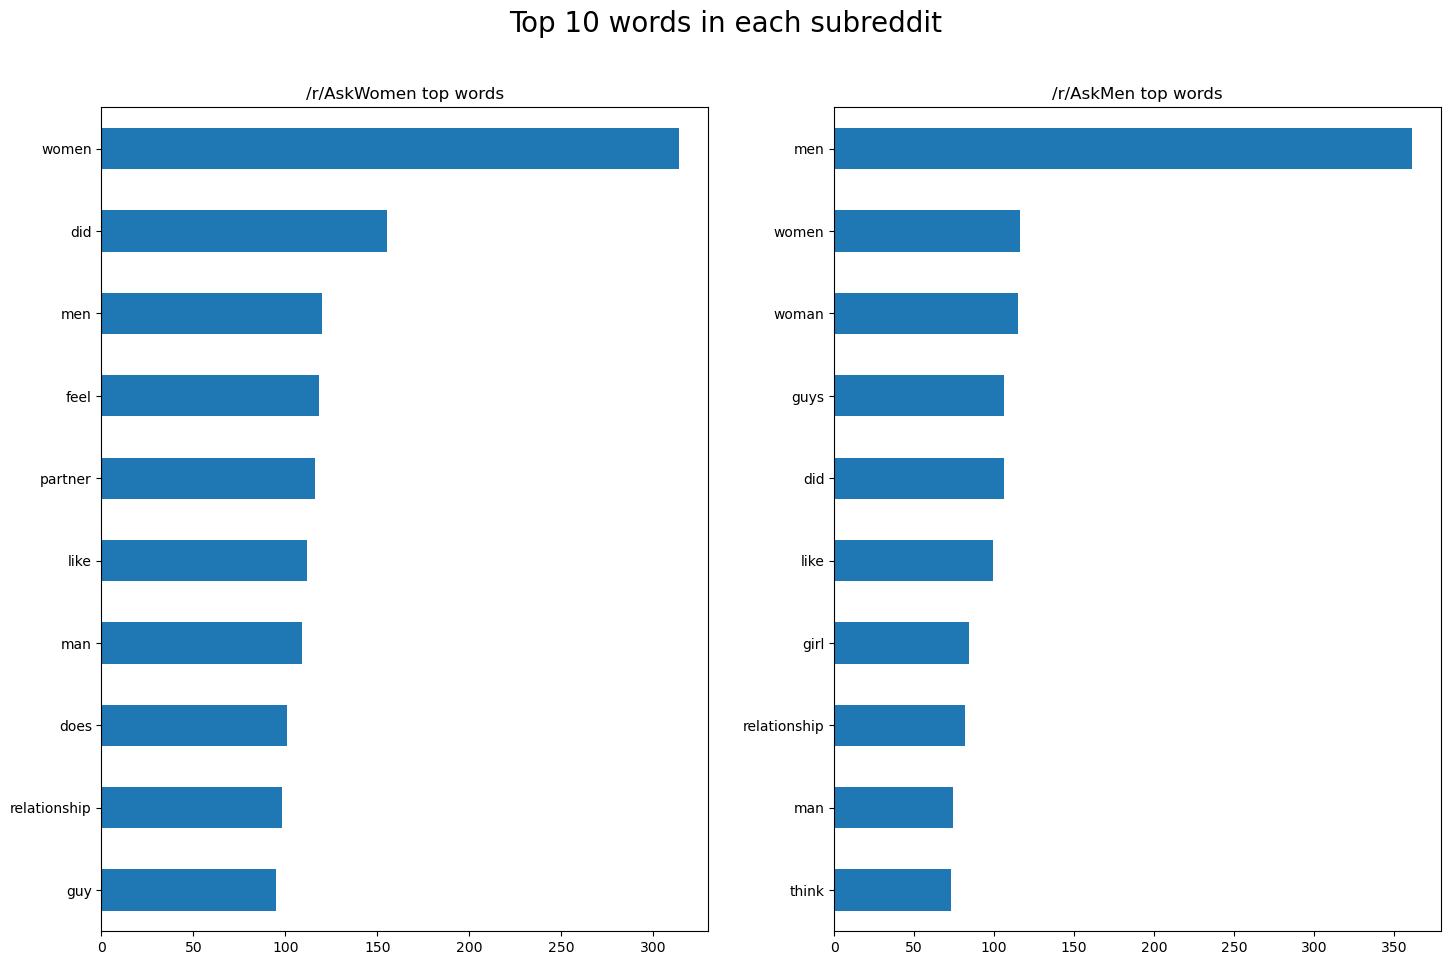

In [48]:
fig, a = plt.subplots(1,2, figsize=(15,10))
plt.suptitle('Top 10 words in each subreddit', fontsize= 20)
a[0].set_title('/r/AskWomen top words')
a[1].set_title('/r/AskMen top words')
women_word.head(10).plot(kind = 'barh', ax=a[0]).invert_yaxis()
men_word.head(10).plot(kind = 'barh', ax=a[1]).invert_yaxis()
fig.tight_layout(pad=2.5)

# Iteration 2

For the second iteration we will repeat the process for iteration 1, but will use the enchant dictionary to check for english text.

## Load data

In [49]:
df2 = pd.read_csv('../Data/02_sub_reddits_data.csv')
df2.head(1)

,subreddit,selftext,author_fullname,gilded,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,...,retrieved_utc,updated_utc,utc_datetime_str,post_hint,preview,author_cakeday,edited_on,author_created_utc,retrieved_on,link_flair_template_id
0,AskMen,NaN,t2_61gxv6mup,0,With two years left of college after this summ...,[],r/AskMen,False,6,NaN,...,1682377122,1682377123,2023-04-24 22:58:29,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
#check the size of the old data frame and the new data frame
len(df), len(df2)

(3992, 5992)

## Clean and select features

In [51]:
clean_df_2=df2[['id', 'subreddit','title', 'utc_datetime_str','num_comments']]

In [52]:
clean_df_2.set_index('id', inplace=True)

In [53]:
#remove any duplicates
clean_df_2.drop_duplicates(inplace= True)

C:\Users\Derik\AppData\Local\Temp\ipykernel_15556\846194371.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df_2.drop_duplicates(inplace= True)


In [54]:
len(clean_df_2)

5992

In [55]:
'''
Used this method from stackoverflow: https://stackoverflow.com/questions/65012603/removing-rows-contains-non-english-words-in-pandas-dataframe
Originally used a package to spell check each word for english, but the package didnt account for slang and puncuation
Regular expression required multiple nested loops which would not be scaleable
'''
clean_df_2= clean_df_2[clean_df_2['title'].map(lambda title: title.isascii())]

In [56]:
clean_df_2.head(2)

,subreddit,title,utc_datetime_str,num_comments
id,,,,
12xzq7k,AskMen,"Men who had an affair, left their wife, and no...",2023-04-24 22:57:05,1
12xzptl,AskMen,"Men, what would your thoughts be after learnin...",2023-04-24 22:56:41,0


## Feature engineering

### Convert timestamp string to a datetime datatyp

In [57]:
clean_df_2.loc[:, 'utc_datetime_str']= pd.to_datetime(clean_df_2.loc[:, 'utc_datetime_str'])

In [58]:
clean_df_2.dtypes

subreddit                   object
title                       object
utc_datetime_str    datetime64[ns]
num_comments                 int64
dtype: object

In [59]:
clean_df_2.head(1)

,subreddit,title,utc_datetime_str,num_comments
id,,,,
12xzq7k,AskMen,"Men who had an affair, left their wife, and no...",2023-04-24 22:57:05,1


### Get the day from the datetime stamp

In [60]:
clean_df_2['day_name'] = clean_df_2['utc_datetime_str'].apply(lambda x: x.day_name())

In [61]:
clean_df_2.head(1)

,subreddit,title,utc_datetime_str,num_comments,day_name
id,,,,,
12xzq7k,AskMen,"Men who had an affair, left their wife, and no...",2023-04-24 22:57:05,1,Monday


### Creating a title word count column

In [62]:
clean_df_2['title_word_count'] = clean_df_2['title'].apply(lambda text: len(text.split()))

In [63]:
clean_df_2['title_word_count'].value_counts(sort=True).head(10)

9     458
8     448
10    400
12    397
11    370
7     357
13    302
14    279
6     270
15    253
Name: title_word_count, dtype: int64

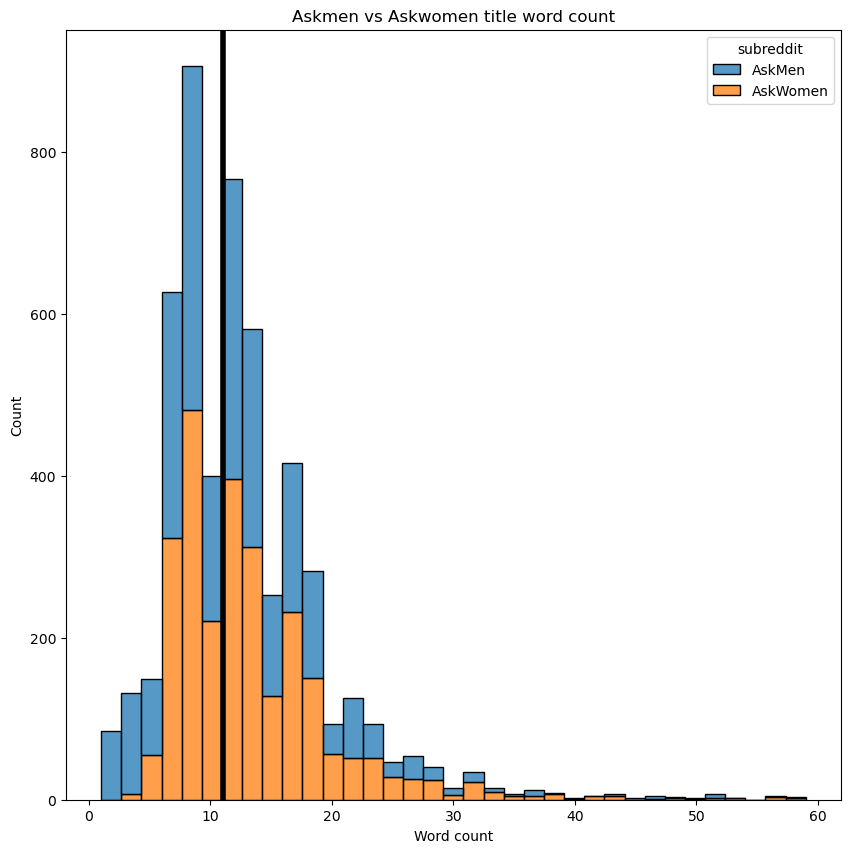

In [64]:
plt.figure(figsize=(10,10))
sns.histplot(data= clean_df_2, multiple ="stack", x = 'title_word_count', hue='subreddit', bins=35)
plt.axvline(x=clean_df_2['title_word_count'].median(), color='black', linewidth=4)
plt.title('Askmen vs Askwomen title word count')
plt.xlabel("Word count")
plt.savefig('../Figures/eda/title_word_count');

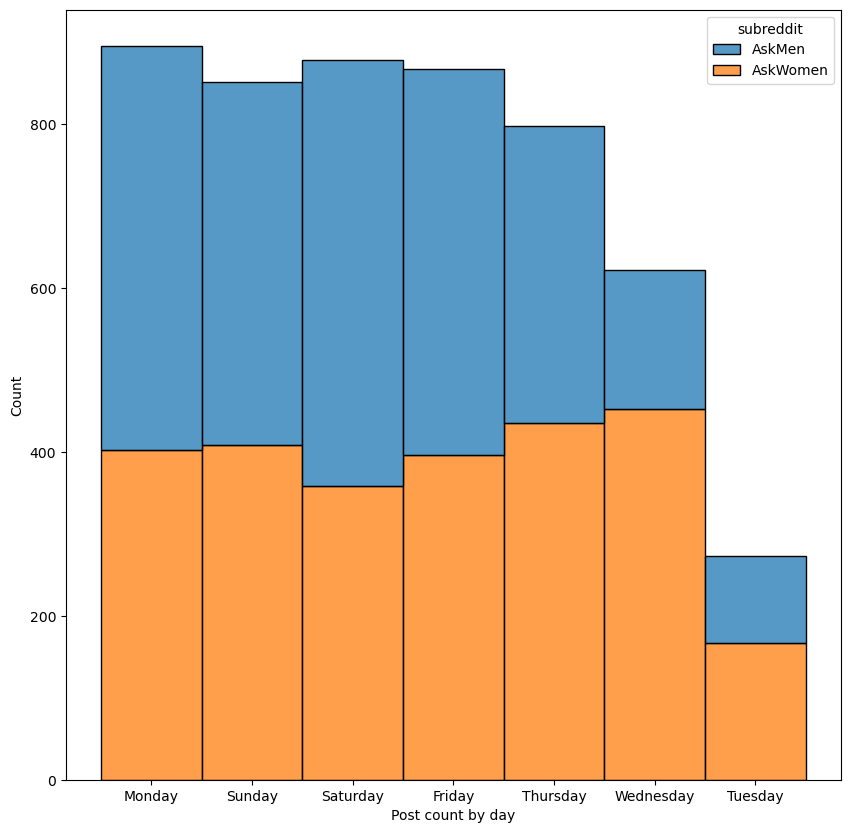

In [65]:
#Overview of post frequencies by day
plt.figure(figsize=(10,10))
sns.histplot(data= clean_df_2, multiple ="stack", x = 'day_name', hue='subreddit')
plt.xlabel("Post count by day")
plt.savefig('../Figures/eda/activity_by_day');

## Sentiment analysis

In [66]:
sent = SentimentIntensityAnalyzer()

In [67]:
#splitting scores into columns
clean_df_2['negative_score'] = [sent.polarity_scores(clean_df_2['title'][i])['neg'] for i in range(len(clean_df_2['title']))]
clean_df_2['neutral_score'] = [sent.polarity_scores(clean_df_2['title'][i])['neu'] for i in range(len(clean_df_2['title']))]
clean_df_2['positive_score'] = [sent.polarity_scores(clean_df_2['title'][i])['pos'] for i in range(len(clean_df_2['title']))]
clean_df_2['compound_score'] = [sent.polarity_scores(clean_df_2['title'][i])['compound'] for i in range(len(clean_df_2['title']))]

In [68]:
clean_df_2.head(2)

,subreddit,title,utc_datetime_str,num_comments,day_name,title_word_count,negative_score,neutral_score,positive_score,compound_score
id,,,,,,,,,,
12xzq7k,AskMen,"Men who had an affair, left their wife, and no...",2023-04-24 22:57:05,1,Monday,12,0.203,0.797,0.0,-0.4215
12xzptl,AskMen,"Men, what would your thoughts be after learnin...",2023-04-24 22:56:41,0,Monday,12,0.000,1.000,0.0,0.0000


<AxesSubplot:title={'center':'Negative setiment score histogram'}, xlabel='negative_score', ylabel='Count'>

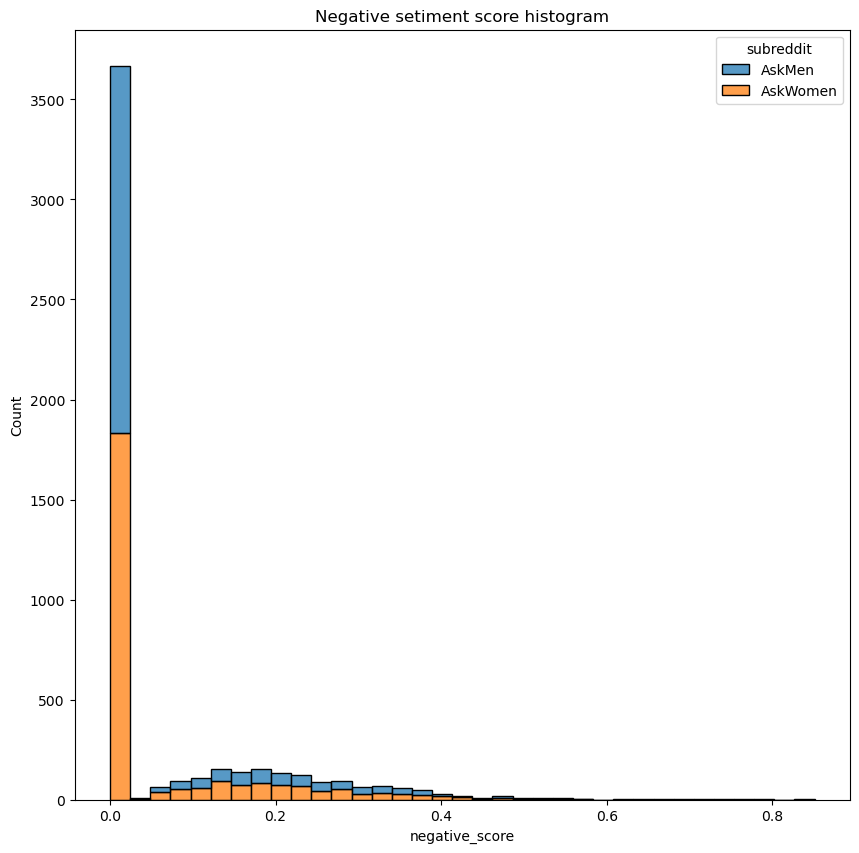

In [71]:
plt.figure(figsize=(10,10))
plt.title('Negative setiment score histogram')
sns.histplot(data= clean_df_2, multiple ="stack", x = 'negative_score', hue='subreddit', bins=35)

<AxesSubplot:title={'center':'Neutral setiment score histogram'}, xlabel='neutral_score', ylabel='Count'>

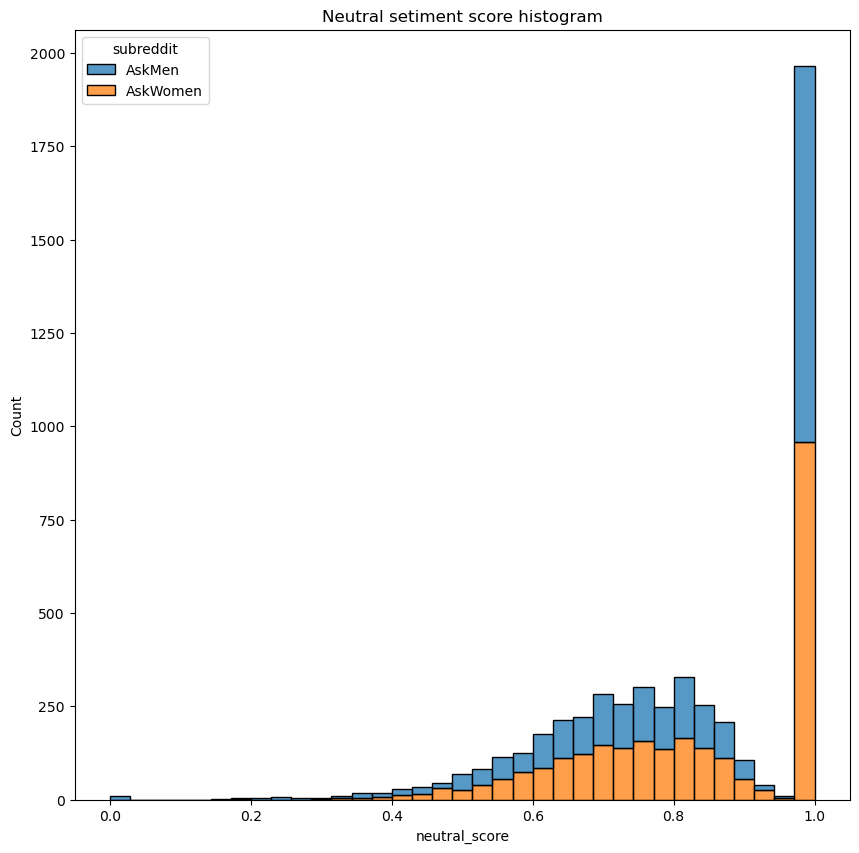

In [76]:
plt.figure(figsize=(10,10))
plt.title('Neutral setiment score histogram')
sns.histplot(data= clean_df_2, multiple ="stack", x = 'neutral_score', hue='subreddit', bins=35)

<AxesSubplot:title={'center':'Positive setiment score histogram'}, xlabel='positive_score', ylabel='Count'>

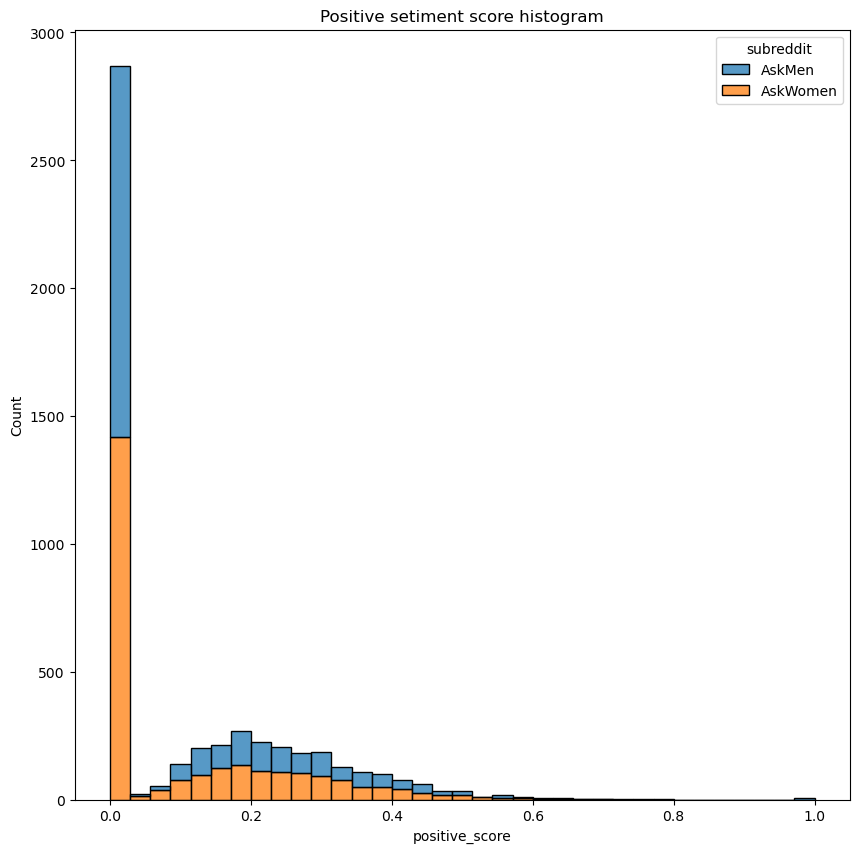

In [75]:
plt.figure(figsize=(10,10))
plt.title('Positive setiment score histogram')
sns.histplot(data= clean_df_2, multiple ="stack", x = 'positive_score', hue='subreddit', bins=35)

<AxesSubplot:title={'center':'Compound setiment score histogram'}, xlabel='compound_score', ylabel='Count'>

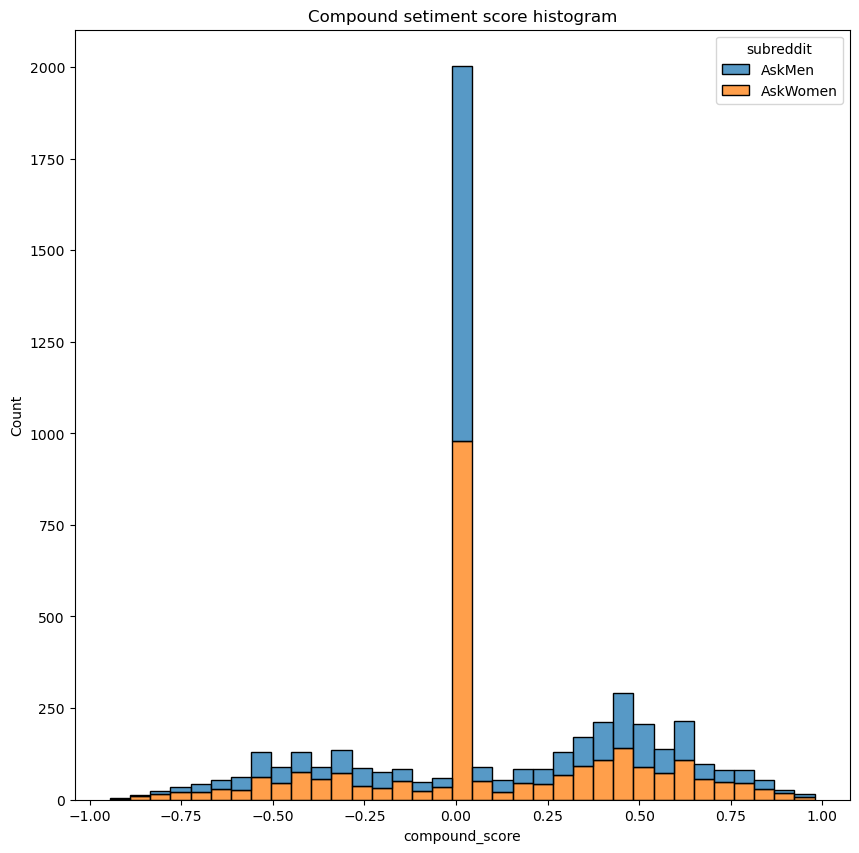

In [73]:
plt.figure(figsize=(10,10))
plt.title('Compound setiment score histogram')
sns.histplot(data= clean_df_2, multiple ="stack", x = 'compound_score', hue='subreddit', bins=35)

Interestingly althought Askmen has more post it appears the distribution of setiment is about the same across the subreddits

## Checking the number of comments column

In [ ]:
clean_df_2['num_comments'].value_counts()

After incorporating the minimum comments feature in our [Data Collection notebook](./Code/01_data_collecting.ipynb) our comment count is a lot more varied.

### Checking removed column

In [ ]:
df2['removed_by_category'].value_counts() / len(df2)

Because we kept the original data set we have fewer moderator removed post. Its more close to half to half.

## Export clean csv

In [ ]:
clean_df_2.to_csv('../Data/02_sub_reddit_data_clean.csv')

# Vectorizing title data

In [ ]:
vect_df_2 = pd.read_csv('../Data/02_sub_reddit_data_clean.csv')

In [ ]:
cvec = CountVectorizer(stop_words = 'english')

In [ ]:
X_2= vect_df_2['title']
X_cv_2 = cvec.fit_transform(X_2)
X_cv_2.shape

In [ ]:
words_df_2 = pd.DataFrame(X_cv_2.todense(), columns=cvec.get_feature_names_out())
words_df_2.head()

As we can see here compared to out vectorizor in the first interation, we no longer have those russian characters.

In [ ]:
women_word_2 = words_df[vect_df_2['subreddit'] == 'AskWomen'].sum().sort_values(ascending=False)
men_word_2 = words_df[vect_df_2['subreddit'] == 'AskMen'].sum().sort_values(ascending=False)

## Visualizing top 10 words

In [ ]:
fig, a = plt.subplots(1,2, figsize=(15,10))
plt.suptitle('Top 10 words in each subreddit', fontsize= 20)
a[0].set_title('/r/AskWomen top words')
a[1].set_title('/r/AskMen top words')
women_word_2.head(10).plot(kind = 'barh', ax=a[0]).invert_yaxis()
men_word_2.head(10).plot(kind = 'barh', ax=a[1]).invert_yaxis()
fig.tight_layout(pad=2.5)
plt.savefig('../Figures/eda/top_ten_words')

Looking at the top ten words within the subreddits we see that the terms women and men have about equal usage in each subreddit. Orginally we thought one would be more common in the respective subreddit, but since they get equal use we can keep those words in out vector.

## Bigrams and trigrams

In [ ]:
# get the subreddit, and n_gram range
def n_gramer(sub, num1, num2):
    #instiatiate countvectorize with placeholders for N gram range
    bi_cvec = CountVectorizer(stop_words= 'english', ngram_range=(num1,num2))
    #assigned the title so we can fit
    bi_X_2= vect_df_2['title']
    #fit and transform title
    bi_X_cv_2 = bi_cvec.fit_transform(bi_X_2)
    #create the n as a data frame
    bi_words_df_2 = pd.DataFrame(bi_X_cv_2.todense(), columns=bi_cvec.get_feature_names_out())
    #return a mask of the dataframe with the specified subreddit
    return bi_words_df_2[vect_df_2['subreddit'] == sub].sum().sort_values(ascending=False)

### Bigrams

In [ ]:
bi_men_word = n_gramer('AskMen', 2 ,2)
bi_men_word.head(10)

In [ ]:
bi_women_word = n_gramer('AskWomen', 2 ,2)
bi_women_word.head(10)

## Trigram

In [ ]:
tri_men_word = n_gramer('AskMen', 3 ,3)
tri_men_word.head(10)

In [ ]:
tri_women_word = n_gramer('AskWomen', 3 ,3)
tri_women_word.head(10)

In [ ]:
print(df2['title'][df2['title'].str.contains('JRF')])

## Quadgram

In [ ]:
tri_men_word = n_gramer('AskMen', 4 ,4)
tri_men_word.head(10)

In [ ]:
tri_women_word = n_gramer('AskWomen', 4 ,4)
tri_women_word.head(10)

In [ ]:
print(clean_df_2['title'][clean_df_2['title'].str.contains('dangerous')])

# Findings

Here it appears theres nothing of concern except for jrf, but upon research the term JRF, it appears to stand for Junior Research Fellowship. Using single grams the most notable words were:
1) ) Women
2) ) Men
3) ) Relationship
4) ) Partner

When using bigram's I noticed these pattern within both subreddit:
1) ) Relationships
2) ) Friendships
3) ) Age
Unique to the women subreddit I noticed women talking about feelings and social media. Unique to the men subreddit I noticed a recurrance of the word "lead". Which I can assume who takes the lead in a relationship.

Intrestingly when I used quadgrams I noticed the Askwomen subreddit mentions a lot of study groups for the Junior Research Fellowship (JRC). The only most notiable one though was the quadgram "obvious reasons like dangerous". Which upon further inspection it was related to relationships. Additionally it appears to be a duplicate value, but looking at the post IDs these are unique so we will keep these values.

From here we can move onto our modeling stage.